In [1]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mpl_toolkits.basemap import Basemap



df = pd.read_csv('final.csv')
df.head(5)

,id,type,start,end,lat,lon,vessel.id,vessel.type,vessel.mmsi,vessel.name,...,encounter.encountered_vessel.destination_port.name,encounter.encountered_vessel.authorizations.authorized,encounter.encountered_vessel.authorizations.unknown,loitering.total_distance_km,loitering.loitering_hours,port.lat,port.lon,port.country,port.name,date
0,f6f02128e9fb54c8ea1bc7987f8d46d7.1,encounter,2015-02-02 23:40:00 UTC,2015-02-03 05:30:00 UTC,-45.583971,-60.494544,000702b7e-e442-5969-7849-35ea992140af,carrier,636015528,PRINCE OF STREAM,...,RECALADA,NaN,ICCAT|CCSBT,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-01
1,1193f92e4aa29480fbfa2ace644fa143.1,encounter,2015-05-29 15:30:00 UTC,2015-05-30 08:30:00 UTC,-45.505687,-60.486374,000702b7e-e442-5969-7849-35ea992140af,carrier,636015528,PRINCE OF STREAM,...,PUNTA ARENAS,NaN,ICCAT|CCSBT,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-01
2,ea7ca74af5300c273a0ce288f129763e.1,encounter,2015-02-19 15:50:00 UTC,2015-02-19 21:40:00 UTC,-45.534999,-60.493174,000702b7e-e442-5969-7849-35ea992140af,carrier,636015528,PRINCE OF STREAM,...,NaN,NaN,ICCAT|CCSBT,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-01
3,7a6a1688b85b7e12770ed2385dd38656.1,encounter,2015-02-17 15:30:00 UTC,2015-02-17 21:10:00 UTC,-45.554563,-60.497218,000702b7e-e442-5969-7849-35ea992140af,carrier,636015528,PRINCE OF STREAM,...,MONTEVIDEO,NaN,CCSBT|ICCAT,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-01
4,5489a5c393dafcb70b4f29d0b52786c7.1,encounter,2015-02-15 17:40:00 UTC,2015-02-16 00:20:00 UTC,-45.554497,-60.495039,000702b7e-e442-5969-7849-35ea992140af,carrier,636015528,PRINCE OF STREAM,...,ZHOUSHAN,NaN,CCSBT|ICCAT,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-01


In [2]:
df.drop_duplicates(subset='id', keep='first', inplace=True)

In [3]:
df.start.sort_values(ascending=True)

169981    2012-01-05 21:40:00 UTC
129734    2012-01-13 20:00:00 UTC
151665    2012-01-14 00:00:00 UTC
143984    2012-01-17 11:10:00 UTC
158470    2012-01-17 11:10:00 UTC
                   ...           
165948    2021-09-30 15:30:00 UTC
130564    2021-09-30 15:40:00 UTC
165570    2021-09-30 17:20:00 UTC
135256    2021-09-30 18:00:00 UTC
135367    2021-09-30 19:50:00 UTC
Name: start, Length: 99874, dtype: object

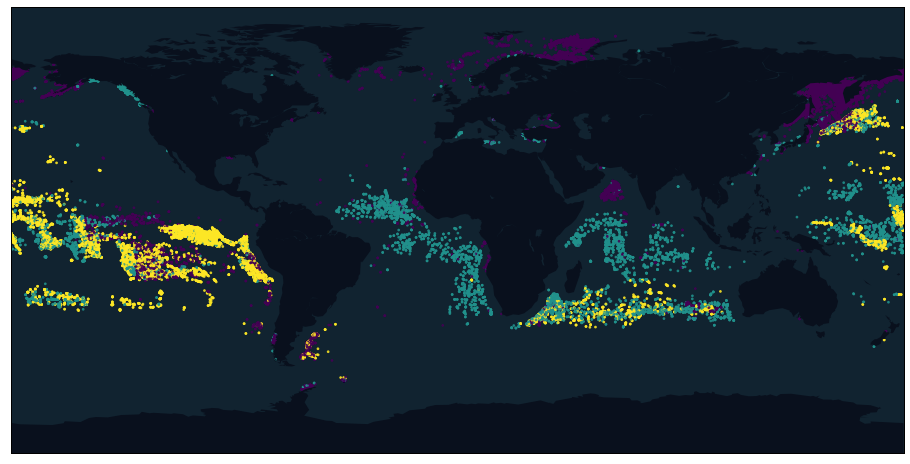

In [4]:
# Set the plot size for this notebook:
plt.figure(figsize=(16,13))
# Always start witht the basemap function to initialize a map
m=Basemap()
 
# Background color:
m.drawmapboundary(fill_color='#112330')

# Continent in green
m.fillcontinents(color='#09101d',lake_color='#112330')

# Show the coast lines in black
m.drawcoastlines(color='black', linewidth=0)

sns.color_palette(['#378656', '#DDB27C', '#9A1225'], 3)
# Show the coast lines
df['labels_enc'] = pd.factorize(df['encounter.authorization_status'])[0]
m.scatter(
    x=df['lon'], 
    y=df['lat'], 
    s=3,
    alpha=0.8, 
    c=df['labels_enc'],
    cmap='viridis',
)
 
plt.show();


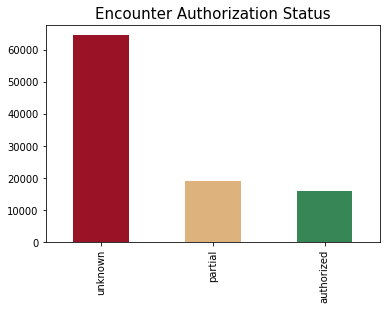

In [5]:
df['encounter.authorization_status'].value_counts().plot(kind='bar', color=['#9A1225', '#DDB27C', '#378656'])
plt.title("Encounter Authorization Status", fontsize=15)
plt.show()

In [6]:
def count_unknown(s):
    if s == 'NA':
        return 0
    else:
        return len(str(s).split('|'))

In [7]:
df['unauthorized_count'] = df['encounter.encountered_vessel.authorizations.unknown'].fillna('NA').apply(count_unknown)


<AxesSubplot:>

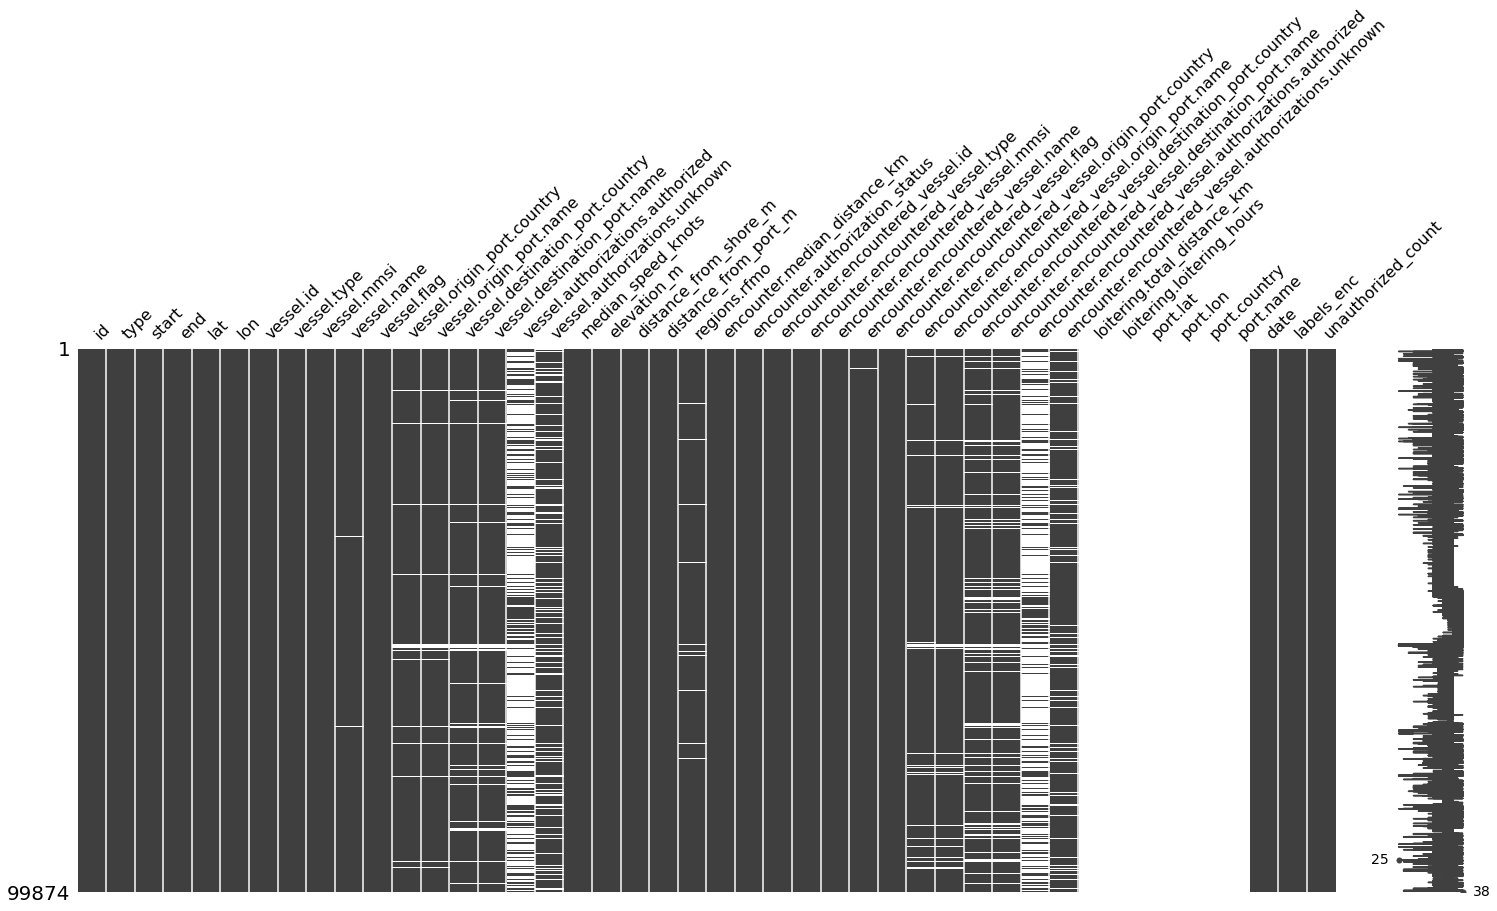

In [8]:
msno.matrix(df)

In [9]:
df['start'] = pd.to_datetime(df['start'])
df['end'] = pd.to_datetime(df['end'])
df['duration'] = (df['end'] - df['start']).dt.seconds /60

In [10]:
df['is_authorized'] = df['encounter.authorization_status'].apply(lambda x: 2 if x == 'authorized' else (1 if x == 'partial' else 0))

In [11]:
# df2 = df.sample(100000, random_state=200)
# df = df.drop(df2.index)


In [12]:
df.shape

(99874, 46)

In [13]:
# Import train_test_split function
X = df[['median_speed_knots', 'elevation_m', 'distance_from_shore_m', 'encounter.median_distance_km', 'duration']]  # Features
X = (X - X.mean()) / X.std() # Normalize the features
y = df['is_authorized']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [14]:
X.head()

,median_speed_knots,elevation_m,distance_from_shore_m,encounter.median_distance_km,duration
0,-1.205345,0.749203,0.209067,-0.093652,-0.334455
1,-1.227035,0.746318,0.203951,-0.170230,1.660237
2,-1.221612,0.751127,0.203951,-0.323387,-0.334455
3,-1.181847,0.756416,0.203951,-0.139599,-0.364227
4,-1.227035,0.756416,0.203951,0.090136,-0.185598


In [15]:
df.is_authorized.value_counts()

0    64643
1    19217
2    16014
Name: is_authorized, dtype: int64

## Multinomial Logistic Regression

In [16]:
# Import Logistic Regression
from sklearn.linear_model import LogisticRegression

# Create a Gaussian Classifier
log_reg_nom = LogisticRegression(multi_class='multinomial', random_state=2021).fit(X_train, y_train)

# Train the model using the training sets
log_reg_nom.fit(X_train, y_train)
y_pred = log_reg_nom.predict(X_test)
print(f"Accuracy = {log_reg_nom.score(X_test, y_test)}")

Accuracy = 0.7797617061041952


### AUC Score

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_cnb = log_reg_nom.predict(X_test)
y_prob_pred_cnb = log_reg_nom.predict_proba(X_test)

#roc auc score
auc = roc_auc_score(y_test, y_prob_pred_cnb, multi_class='ovo', average='weighted')
print(f"Mean AUC of all classes = {auc}")

Mean AUC of all classes = 0.8739065368995239


In [18]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_prob_pred_cnb[:,i], pos_label=i)

## K Nearest Neighbors

In [19]:
#Import knearest neighbors Classifier model
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(n_neighbors=10)

#Train the model using the training sets
knn.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

In [20]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8166405233120849


### AUC Score

In [21]:
y_pred_cnb = knn.predict(X_test)
y_prob_pred_cnb = knn.predict_proba(X_test)

#roc auc score
auc = roc_auc_score(y_test, y_prob_pred_cnb, multi_class='ovo', average='weighted')
print(f"Mean AUC of all classes = {auc}")

Mean AUC of all classes = 0.9177766727623441


In [22]:
# roc curve for classes
f = {}
t = {}
thre ={}

n_class = 3

for i in range(n_class):    
    f[i], t[i], thre[i] = roc_curve(y_test, y_prob_pred_cnb[:,i], pos_label=i)

## Random Forest Classifier

In [23]:
# Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

# Train the model using the training sets
clf.fit(X_train,y_train)
# Predict the response for test dataset
y_pred=clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print(f"Accuracy = {clf.score(X_test, y_test)}")

Accuracy = 0.9189667256282749


### AUC Score

In [24]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_cnb = clf.predict(X_test)
y_prob_pred_cnb = clf.predict_proba(X_test)

#roc auc score
auc = roc_auc_score(y_test, y_prob_pred_cnb, multi_class='ovo', average='weighted')
print(f"Mean AUC of all classes = {auc}")

Mean AUC of all classes = 0.9796861496217015


### ROC Curves

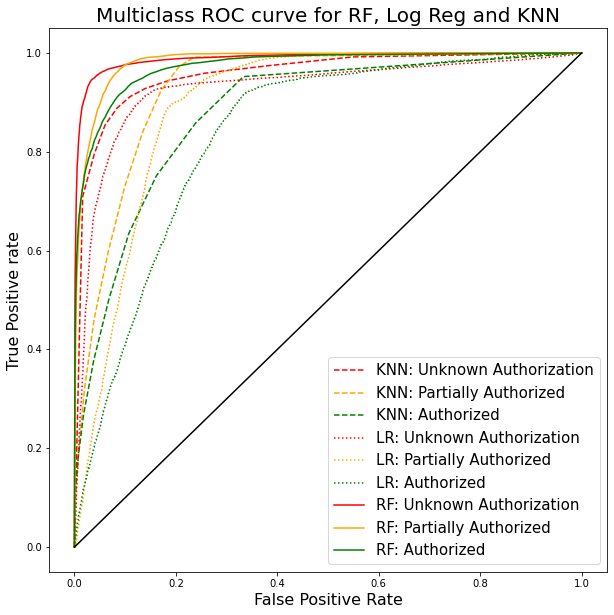

In [25]:
# roc curve for classes
fp = {}
tp = {}
thres ={}

n_class = 3

for i in range(n_class):    
    fp[i], tp[i], thres[i] = roc_curve(y_test, y_prob_pred_cnb[:,i], pos_label=i)
# plotting  
fig = plt.figure(figsize=(10,10))
plt.plot(f[0], t[0], linestyle='--',color='red', label='KNN: Unknown Authorization')
plt.plot(f[1], t[1], linestyle='--',color='orange', label='KNN: Partially Authorized')
plt.plot(f[2], t[2], linestyle='--',color='green', label='KNN: Authorized')
plt.plot(fpr[0], tpr[0], linestyle='dotted',color='red', label='LR: Unknown Authorization')
plt.plot(fpr[1], tpr[1], linestyle='dotted',color='orange', label='LR: Partially Authorized')
plt.plot(fpr[2], tpr[2], linestyle='dotted',color='green', label='LR: Authorized')
plt.plot(fp[0], tp[0], linestyle='-',color='red', label='RF: Unknown Authorization')
plt.plot(fp[1], tp[1], linestyle='-',color='orange', label='RF: Partially Authorized')
plt.plot(fp[2], tp[2], linestyle='-',color='green', label='RF: Authorized')
plt.plot([0, 1], [0, 1],color='black')
#plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plt.title('Multiclass ROC curve for RF, Log Reg and KNN', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive rate', fontsize=16)
plt.legend(loc='best', fontsize=15)
plt.savefig('Multiclass ROC',dpi=300);  

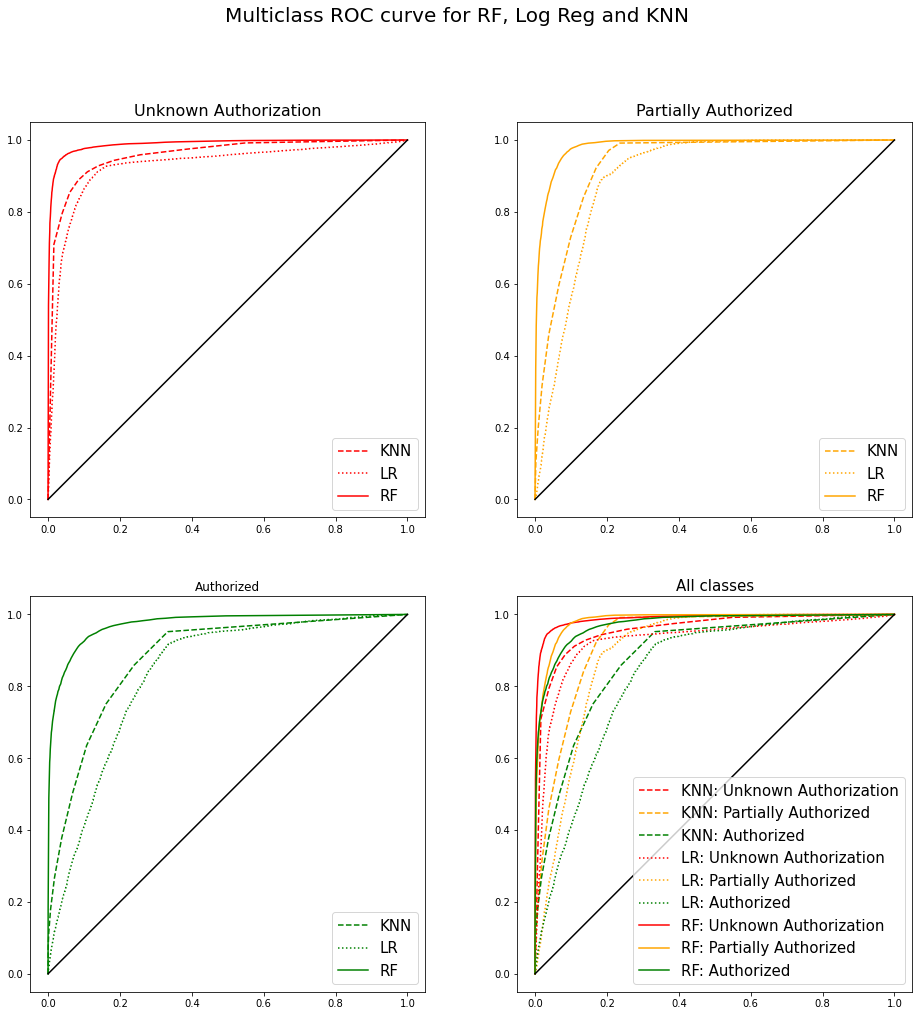

In [51]:
fig, (axs) = plt.subplots(2, 2, figsize=(16,16))
fig.suptitle('Multiclass ROC curve for RF, Log Reg and KNN', fontsize=20)
axs[0, 0].plot(f[0], t[0], linestyle='--',color='red', label='KNN')
axs[0, 0].plot(fpr[0], tpr[0], linestyle='dotted',color='red', label='LR')
axs[0, 0].plot(fp[0], tp[0], linestyle='-',color='red', label='RF')
axs[0, 0].plot([0, 1], [0, 1],color='black')
axs[0, 0].legend(loc='best', fontsize=15)
axs[0, 0].set_aspect('equal')
axs[0, 0].set_title('Unknown Authorization', fontsize=16)


axs[0, 1].plot(f[1], t[1], linestyle='--',color='orange', label='KNN')
axs[0, 1].plot(fpr[1], tpr[1], linestyle='dotted',color='orange', label='LR')
axs[0, 1].plot(fp[1], tp[1], linestyle='-',color='orange', label='RF')
axs[0, 1].plot([0, 1], [0, 1],color='black')
axs[0, 1].legend(loc='best', fontsize=15)
axs[0, 1].set_aspect('equal')
axs[0, 1].set_title('Partially Authorized', fontsize=16)


axs[1, 0].plot(f[2], t[2], linestyle='--',color='green', label='KNN')
axs[1, 0].plot(fpr[2], tpr[2], linestyle='dotted',color='green', label='LR')
axs[1, 0].plot(fp[2], tp[2], linestyle='-',color='green', label='RF')
axs[1, 0].plot([0, 1], [0, 1],color='black')
axs[1, 0].legend(loc='best', fontsize=15)
axs[1, 0].set_aspect('equal')
axs[1, 0].set_title('Authorized')

axs[1, 1].plot(f[0], t[0], linestyle='--',color='red', label='KNN: Unknown Authorization')
axs[1, 1].plot(f[1], t[1], linestyle='--',color='orange', label='KNN: Partially Authorized')
axs[1, 1].plot(f[2], t[2], linestyle='--',color='green', label='KNN: Authorized')
axs[1, 1].plot(fpr[0], tpr[0], linestyle='dotted',color='red', label='LR: Unknown Authorization')
axs[1, 1].plot(fpr[1], tpr[1], linestyle='dotted',color='orange', label='LR: Partially Authorized')
axs[1, 1].plot(fpr[2], tpr[2], linestyle='dotted',color='green', label='LR: Authorized')
axs[1, 1].plot(fp[0], tp[0], linestyle='-',color='red', label='RF: Unknown Authorization')
axs[1, 1].plot(fp[1], tp[1], linestyle='-',color='orange', label='RF: Partially Authorized')
axs[1, 1].plot(fp[2], tp[2], linestyle='-',color='green', label='RF: Authorized')
axs[1, 1].plot([0, 1], [0, 1],color='black')
axs[1, 1].legend(loc='best', fontsize=15)

axs[1, 1].set_aspect('equal')
axs[1, 1].set_title('All classes', fontsize=15)

plt.show()

In [49]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5)
print("Random forest with %0.2f accuracy with a standard deviation of %0.2f using cross-validation" % (scores.mean(), scores.std()))

Random forest with 0.93 accuracy with a standard deviation of 0.03 using cross-validation


In [50]:
def err_metric(CM): 
      
    TN = CM.iloc[0,0]
    FN = CM.iloc[1,0]
    TP = CM.iloc[1,1]
    FP = CM.iloc[0,1]
    precision =(TP)/(TP+FP)
    accuracy_model  =(TP+TN)/(TP+TN+FP+FN)
    recall_score  =(TP)/(TP+FN)
    specificity_value =(TN)/(TN + FP)
      
    False_positive_rate =(FP)/(FP+TN)
    False_negative_rate =(FN)/(FN+TP)
    f1_score =2*(( precision * recall_score)/( precision + recall_score))
    print("Precision value of the model: ",precision)
    print("Accuracy of the model: ",accuracy_model)

target = clf.predict(X_test)
targetclass_prob = clf.predict_proba(X_test)[:, 1]
confusion_matrix = pd.crosstab(y_test,target)
err_metric(confusion_matrix)

Precision value of the model:  0.9252067601582165
Accuracy of the model:  0.9715911400121926


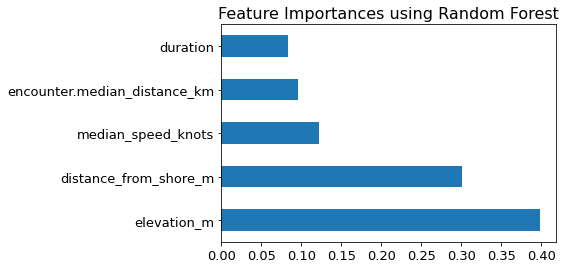

In [51]:
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp.plot(kind='barh', fontsize=13)
plt.title('Feature Importances using Random Forest', fontsize=16)
plt.show()

In [52]:
X.corr()

,median_speed_knots,elevation_m,distance_from_shore_m,encounter.median_distance_km,duration
median_speed_knots,1.000000,-0.474115,0.436371,-0.186067,-0.160470
elevation_m,-0.474115,1.000000,-0.717027,0.154465,0.199210
distance_from_shore_m,0.436371,-0.717027,1.000000,-0.158022,-0.206235
encounter.median_distance_km,-0.186067,0.154465,-0.158022,1.000000,-0.044449
duration,-0.160470,0.199210,-0.206235,-0.044449,1.000000


In [54]:
X_train.value_counts()

median_speed_knots  elevation_m  distance_from_shore_m  encounter.median_distance_km  duration 
 0.222575           -0.807369     1.094140              -0.231493                     -0.691713    3
 1.580002           -1.689283     0.301156              -0.384649                      0.141889    3
 1.377563           -1.264195     0.372780              -0.690963                     -0.870343    3
-0.240143           -1.288238     0.306272              -0.537806                     -0.751257    3
 0.963647           -1.218512     2.710806              -0.415281                     -0.602399    3
                                                                                                  ..
-0.513075            0.716023    -0.491829              -0.369334                      0.648005    1
                     0.722755     0.262785              -0.369334                      1.213664    1
                     0.723236    -0.722051              -0.124283                     -0.870343 

In [55]:
y_train.value_counts()

0    45254
1    13392
2    11265
Name: is_authorized, dtype: int64

In [56]:
y_test.value_counts()

0    19389
1     5825
2     4749
Name: is_authorized, dtype: int64

In [57]:
pd.Series(y_pred.tolist()).value_counts()

0    19374
1     6243
2     4346
dtype: int64

In [58]:
# from sklearn.tree import export_graphviz
# import pydot# Pull out one tree from the forest
# tree = clf.estimators_[5]# Export the image to a dot file
# feature_list = list(X.columns)
# export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)# Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')# Write graph to a png file
# graph.write_png('tree.png')

<AxesSubplot:xlabel='is_authorized', ylabel='elevation_m'>

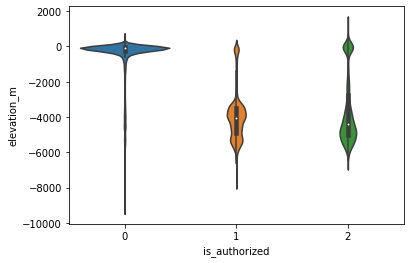

In [59]:
sns.violinplot(x='is_authorized', y='elevation_m', data=df)

<AxesSubplot:xlabel='is_authorized', ylabel='distance_from_port_m'>

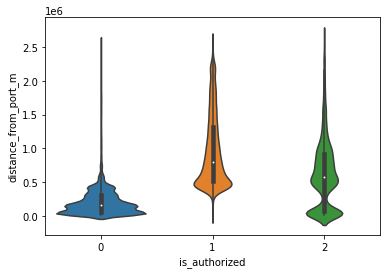

In [61]:
sns.violinplot(x='is_authorized', y='distance_from_port_m', data=df)

<AxesSubplot:xlabel='distance_from_port_m', ylabel='Count'>

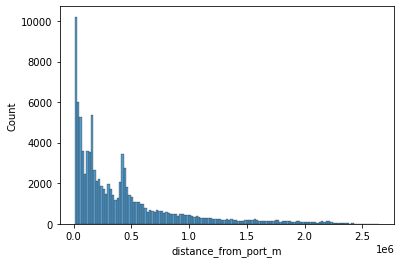

In [62]:
sns.histplot(x='distance_from_port_m', data=df)

<AxesSubplot:xlabel='elevation_m', ylabel='Count'>

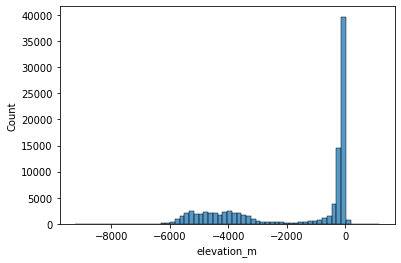

In [60]:
sns.histplot(x='elevation_m', data=df)

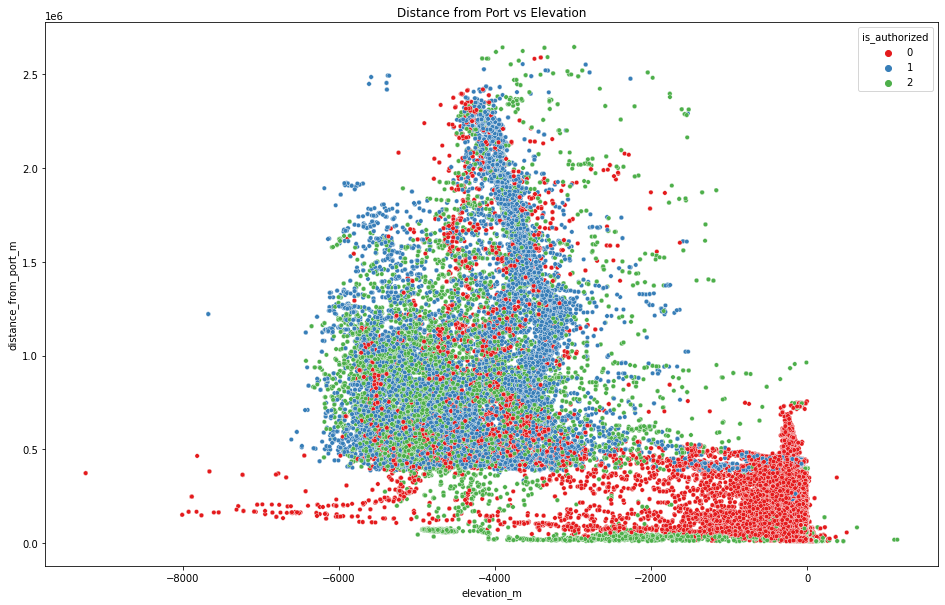

In [59]:
plt.figure(figsize=(16,10))
sns.scatterplot(x='elevation_m', y='distance_from_port_m', hue='is_authorized', data=df, s=20, palette="Set1").set(title='Distance from Port vs Elevation')
#plt.legend(['unauthorized', 'partially authorized', 'authorized'], loc='upper right')
plt.show()